# Dataset Construction

In [13]:
import os
import sys
import pickle
from glob import glob
from time import time
from tqdm import tqdm
from collections import Counter

# data processing
import cv2
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline

# pytorch
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms, models, utils
from torch.utils.data import Dataset, DataLoader, random_split
print(f'Pytorch version: {torch.__version__}')

# device setting
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'This notebook use {device}')

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

Pytorch version: 1.6.0
This notebook use cuda:0


In [14]:
!pwd

/opt/ml/code


In [15]:
# 파일 경로 사용자 정의
class path:
    data = '../input/data'
    train = '../input/data/train'
    train_img = f'{train}/images'
    train_df = f'{train}/train.csv'
    test = '../input/data/eval'
    test_img = f'{test}/images'
    test_df = f'{test}/info.csv'

## 1. Check file extensions

- 이미지 폴더에 있는 모든 확장자명 뽑아보기

In [16]:
folders = glob(f'{path.train_img}/*')
file_exts = []
for folder_name in folders:
    files = glob(f'{folder_name}/*')
    for file_name in files:
        ext = file_name.split('.')[-1].lower()
        file_exts.append(ext)

In [17]:
for ext, count in Counter(file_exts).items():
    print(f'.{ext:4}의 개수: {count}')

.jpg 의 개수: 18035
.jpeg의 개수: 354
.png 의 개수: 511


대부분의 파일이 `.jpg`인 것을 볼 수 있다. 약 900개 정도가 다른 확장명인 것을 볼 수 있다. 하지만 파일을 불러올 때 큰 이상은 없으므로 변경하지 않기로 결정!

## 2. Create train_modified.csv

- 피처의 조합별 클래스 정의

In [18]:
from itertools import product

mask = ['wear', 'incorrect', 'not wear']
gender = ['male', 'female']
age_bin = [0, 1, 2]

combs = list(product(mask, gender, age_bin))
num2class = {idx: value for idx, value in enumerate(combs)}
class2num = {value: idx for idx, value in enumerate(combs)}
class2num

{('wear', 'male', 0): 0,
 ('wear', 'male', 1): 1,
 ('wear', 'male', 2): 2,
 ('wear', 'female', 0): 3,
 ('wear', 'female', 1): 4,
 ('wear', 'female', 2): 5,
 ('incorrect', 'male', 0): 6,
 ('incorrect', 'male', 1): 7,
 ('incorrect', 'male', 2): 8,
 ('incorrect', 'female', 0): 9,
 ('incorrect', 'female', 1): 10,
 ('incorrect', 'female', 2): 11,
 ('not wear', 'male', 0): 12,
 ('not wear', 'male', 1): 13,
 ('not wear', 'male', 2): 14,
 ('not wear', 'female', 0): 15,
 ('not wear', 'female', 1): 16,
 ('not wear', 'female', 2): 17}

- 파일명을 가지고 새로운 데이터프레임 생성

In [19]:
def get_mask_value(x):
    if x == 'incorrect_mask':
        return 'incorrect'
    elif x == 'normal':
        return 'not wear'
    else:
        return 'wear'

In [20]:
info_dict = {'age': [], 'gender': [], 'mask': [], 'path': []}

for folder_name in folders:
    elem = folder_name.split('/')[-1].split('_')
    gender, age = elem[1], int(elem[-1]) 
    files = glob(f'{folder_name}/*')
    for file_path in files:
        file_name = file_path.split('/')[-1].split('.')[0]
        info_dict['age'].append(age)
        info_dict['gender'].append(gender)
        info_dict['mask'].append(get_mask_value(file_name))
        info_dict['path'].append(file_path)

In [21]:
df = pd.DataFrame(info_dict)
df.head()

,age,gender,mask,path
0,51,female,wear,../input/data/train/images/000523_female_Asian...
1,51,female,not wear,../input/data/train/images/000523_female_Asian...
2,51,female,wear,../input/data/train/images/000523_female_Asian...
3,51,female,wear,../input/data/train/images/000523_female_Asian...
4,51,female,incorrect,../input/data/train/images/000523_female_Asian...


- `age_bin` 피처 생성: "30대 미만"=0, "30대 이상, 60대 미만"=1, "60대 이상"=2로 설정

In [22]:
def get_age_bin(x): 
    if x <30:
        return 0
    elif x >=30 and x <58:
        return 1
    else:
        return 2
    
df['age_bin'] = df.age.map(get_age_bin)
df.head()

,age,gender,mask,path,age_bin
0,51,female,wear,../input/data/train/images/000523_female_Asian...,1
1,51,female,not wear,../input/data/train/images/000523_female_Asian...,1
2,51,female,wear,../input/data/train/images/000523_female_Asian...,1
3,51,female,wear,../input/data/train/images/000523_female_Asian...,1
4,51,female,incorrect,../input/data/train/images/000523_female_Asian...,1


- `gender`, `mask`, `age_bin`을 가지고 각 데이터별 라벨 계산

In [23]:
df['target'] = df.apply(lambda x: class2num[(x['mask'], x['gender'], x['age_bin'])], axis=1)
df.head()

,age,gender,mask,path,age_bin,target
0,51,female,wear,../input/data/train/images/000523_female_Asian...,1,4
1,51,female,not wear,../input/data/train/images/000523_female_Asian...,1,16
2,51,female,wear,../input/data/train/images/000523_female_Asian...,1,4
3,51,female,wear,../input/data/train/images/000523_female_Asian...,1,4
4,51,female,incorrect,../input/data/train/images/000523_female_Asian...,1,10


In [24]:
df['target'].value_counts()

3     3660
4     3345
0     2745
1     1570
5     1285
2      895
9      732
15     732
16     669
10     669
6      549
12     549
13     314
7      314
17     257
11     257
8      179
14     179
Name: target, dtype: int64

- `train_modified.csv`로 저장

In [25]:
df.to_csv(f'{path.train}/train_modified_2.csv', mode='w')

## 3. Create dataset for model

In [26]:
class MaskDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
    
    def __getitem__(self, idx):
        current_data = self.data.iloc[idx]
        target = current_data.target
        img = np.array(Image.open(current_data.path))
        
        if self.transform:
            img = self.transform(img)
        
        return img, target
        
    def __len__(self):
        return len(self.data)

In [27]:
dataset = MaskDataset(f'{path.train}/train_modified.csv')
print('Size of dataset :', len(dataset))
print('Shape of image :', dataset[0][0].shape)

Size of dataset : 18900
Shape of image : (512, 384, 3)


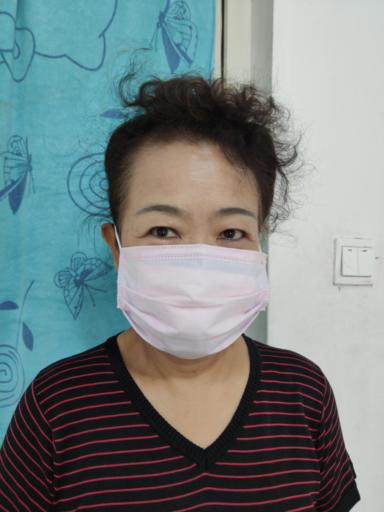

In [28]:
# 이미지 확인하기
img = Image.fromarray(dataset[0][0])
img